In [47]:
!pip install catboost

In [48]:
!pip install pytorch-tabnet

In [49]:
# General libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Skleran modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler #check if we really need it
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import KFold

# Tensorflow modules
from tensorflow.keras.models import Model, Sequential
import tensorflow.keras.layers as L
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import *

# Tabnet import
import pytorch_tabnet
from pytorch_tabnet.tab_model import TabNetRegressor
import torch


from catboost import CatBoostRegressor

In [50]:
# Common variables
RANDOM_SEED = 42
VAL_SIZE = 0.15 # the size of a validation sample
np.random.seed(RANDOM_SEED)
pd.set_option("display.max_rows", None)

In [51]:
# Common functions

# A target metric function
def mape(y_true, y_pred):    
    return np.mean(np.abs((y_pred-y_true)/y_true))

# A function for distribution visualisation
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 5, rows * 3))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

In [52]:
df = pd.read_csv('land_lots_eda_available.csv')

In [53]:
df.head()

,id,status,price,pricePerOne,estimatePrice,rentRate,rentalYield,purpose,koatuuLocation,ownerEdrpou,...,renterEdrpou,isAvailable,region_id,estimateMonth,estimateDay,estimateYear,daysDelta,daysRentPayDelta,daysRentPayDeltaSign,area_win
0,740,3,120000,61137,42477,3812,2.6,1,"Іванків, Іванківська, Вишгородський, Київська,...",3578305088,...,41102844,True,3222055100,12,28,2021,68,-66,0,1.9628
1,739,3,60000,53893,5917,967,1.3,1,"Іванківська, Вишгородський, Київська, Україна",3578305088,...,41102844,True,3222086800,12,28,2021,68,-66,0,1.1133
2,737,3,680000,67156,204989,21120,2.5,1,"Подо-Калинівка, Ювілейна, Херсонський, Херсонс...",2284411333,...,41101589,True,6525082500,9,13,2021,174,-66,0,10.1256
3,736,3,385000,67444,142833,22995,4.8,1,"Щасливе, Ювілейна, Херсонський, Херсонська, Ук...",2520006184,...,41101589,True,6525085600,9,13,2021,174,-66,0,5.7084
4,735,3,400000,56441,187952,22424,4.5,1,"Зеленопідська, Каховський, Херсонська, Україна",2762921072,...,41101589,True,6523584000,12,9,2021,87,299,1,7.0870


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359 entries, 0 to 358
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    359 non-null    int64  
 1   status                359 non-null    int64  
 2   price                 359 non-null    int64  
 3   pricePerOne           359 non-null    int64  
 4   estimatePrice         359 non-null    int64  
 5   rentRate              359 non-null    int64  
 6   rentalYield           359 non-null    float64
 7   purpose               359 non-null    int64  
 8   koatuuLocation        359 non-null    object 
 9   ownerEdrpou           359 non-null    int64  
 10  renterCompany         359 non-null    float64
 11  renterEdrpou          359 non-null    int64  
 12  isAvailable           359 non-null    bool   
 13  region_id             359 non-null    int64  
 14  estimateMonth         359 non-null    int64  
 15  estimateDay           3

In [55]:
df.area_win.max()

10.276

In [56]:
df.daysRentPayDeltaSign.value_counts(0)

0    339
1     20
Name: daysRentPayDeltaSign, dtype: int64

In [57]:
df.renterEdrpou.nunique

<bound method IndexOpsMixin.nunique of 0      41102844
1      41102844
2      41101589
3      41101589
4      41101589
5      41101589
6      41101589
7      41101589
8      41101589
9      41099127
10     41099127
11     41102163
12     41102163
13     41103827
14     41101589
15     41101589
16     41101589
17     41101589
18     41101589
19     41101589
20     41101589
21     41101589
22     41105190
23     41105190
24     41105190
25     41105190
26     41105190
27     41105190
28     41105190
29     41105190
30     41105190
31     41105190
32     41105190
33     34264631
34     41101589
35     41101589
36     41101589
37     41101589
38     41101589
39     41101589
40     41101589
41     41101589
42     41101589
43     41101589
44     41107067
45     41107067
46     41107067
47     41102163
48     41102163
49     41103827
50     41104731
51     41104731
52     41104731
53     41104731
54     41104731
55     41104731
56     41104731
57     41104731
58     41104731
59     41104731
6

In [58]:
df.renterEdrpou.value_counts()

41101589    115
34264631     61
41104731     51
41105190     34
41102163     26
41107067     25
41103827     24
41102844     12
41099127      5
41104967      3
41481188      3
Name: renterEdrpou, dtype: int64

In [59]:
# Getting rid of the id feature
df.drop(['id'], axis = 1, inplace = True)

In [60]:
# Also, because the total price of the lot heavily depends on the area of the lot maybe it makes sense to 
# set the target variable to pricePerOne, not actually price

#### Let's now try to split features into numerical and categorical

In [61]:
df['area_win'].value_counts()

10.2760    26
2.0000     13
0.1575      5
0.4366      3
1.0000      3
3.7000      2
2.2733      2
0.6464      2
1.5000      2
1.5045      2
1.3640      2
1.8259      1
2.8861      1
1.5489      1
2.3586      1
0.2420      1
3.5777      1
2.7469      1
3.7178      1
8.3514      1
6.1331      1
6.6213      1
3.8459      1
1.0891      1
3.6700      1
2.9538      1
3.2700      1
1.0886      1
2.9142      1
8.4516      1
4.7839      1
10.0290     1
1.6534      1
3.2499      1
3.5499      1
1.0887      1
2.2186      1
8.4452      1
1.8903      1
3.3464      1
3.1303      1
5.7000      1
6.9500      1
3.1395      1
1.9544      1
2.3253      1
6.3793      1
1.8872      1
1.6921      1
0.6045      1
1.5193      1
1.5507      1
3.2399      1
0.7085      1
0.2874      1
6.4232      1
7.0870      1
9.3918      1
2.3526      1
7.2828      1
5.6385      1
2.6663      1
8.9701      1
2.7280      1
0.4435      1
5.3498      1
3.2703      1
3.9400      1
0.6052      1
0.1801      1
6.6391      1
0.8568

In [62]:
#Numerical columns
num_col = ['pricePerOne', 'estimatePrice', 'rentalYield', 'daysDelta', 'daysRentPayDelta', 'area_win', 'price']

In [63]:
#Categorical columns
cat_col = ['status', 'region_id', 'rentRate', 'purpose', 'koatuuLocation', 'ownerEdrpou', 'renterCompany', 'estimateMonth', 'estimateDay', 'estimateYear', 'daysRentPayDeltaSign']

In [64]:
# Setting target variable
y = df['price']

## Data Processing

#### Let's first figure out the correlation between numeric variables including target ones

In [65]:
df[num_col].corr()

,pricePerOne,estimatePrice,rentalYield,daysDelta,daysRentPayDelta,area_win,price
pricePerOne,1.000000,0.001515,-0.339008,0.297909,0.027341,-0.080137,0.257846
estimatePrice,0.001515,1.000000,-0.003954,0.125492,0.119987,0.153728,0.140434
rentalYield,-0.339008,-0.003954,1.000000,-0.151742,0.068028,0.115887,-0.018683
daysDelta,0.297909,0.125492,-0.151742,1.000000,-0.128190,-0.097450,0.015732
daysRentPayDelta,0.027341,0.119987,0.068028,-0.128190,1.000000,0.098030,0.096097
area_win,-0.080137,0.153728,0.115887,-0.097450,0.098030,1.000000,0.878185
price,0.257846,0.140434,-0.018683,0.015732,0.096097,0.878185,1.000000


#### Let's visualize correlations better with Seaborn

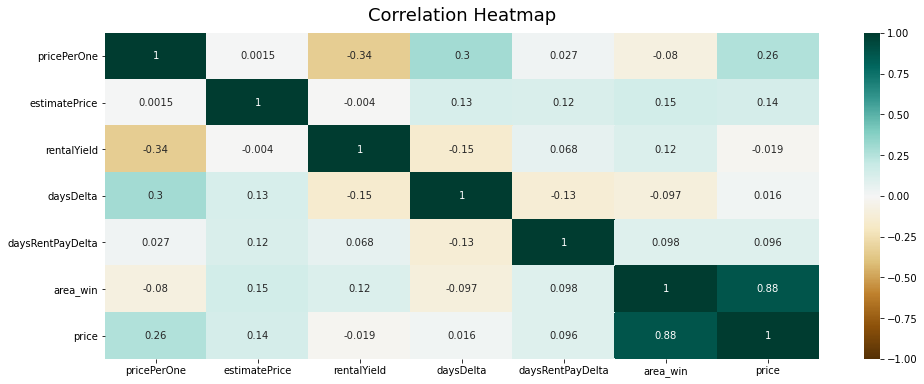

In [66]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df[num_col].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

As we can see - there is a very high correlation between the price and are_win. So, I suggest to take a pricePerOne (price per one hectare) as a target variable and remove the **price** feature

In [67]:
y = df['pricePerOne']

In [68]:
# Removing price and pricePerOne from numerical features list
spare_elem = {'pricePerOne', 'price'} 
num_col = [elem for elem in num_col if elem not in spare_elem]

In [69]:
num_col

['estimatePrice', 'rentalYield', 'daysDelta', 'daysRentPayDelta', 'area_win']

## Model 0: Default model
Let's try to build a default naive model based on only on the lot location. Later we will compare our results with this default model

In [70]:
# Splitting data
data_train, data_test = train_test_split(df, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [71]:
# Default model
predicts = []

for index, row in pd.DataFrame(data_test[['koatuuLocation']]).iterrows():
    query = f"koatuuLocation == '{row[0]}'"    
    
    #Because the total price of the lot depends heavily on the area of the lot, we will take price per 1 unit as a target
    predicts.append(data_train.query(query)['pricePerOne'].median())    

predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# Rounding
predicts = (predicts // 1000) * 1000

# Evaluating precision
print(f"The precision of the default model based on MAPE metric is: {(mape(data_test['pricePerOne'], predicts.values[:, 0]))*100:0.2f}%")

The precision of the default model based on MAPE metric is: 34.29%


## Data Analysis

Let's analyze the numerical data first

In [72]:
df[num_col].head()

,estimatePrice,rentalYield,daysDelta,daysRentPayDelta,area_win
0,42477,2.6,68,-66,1.9628
1,5917,1.3,68,-66,1.1133
2,204989,2.5,174,-66,10.1256
3,142833,4.8,174,-66,5.7084
4,187952,4.5,87,299,7.0870


As we can see the scales of our numerical values are quite different. Let's apply Standard Scaler to them

In [73]:
scaled_features = MinMaxScaler().fit_transform(df[num_col].values)

In [74]:
df_num = pd.DataFrame(scaled_features, index=df[num_col].index, columns=df[num_col].columns)

In [75]:
df_num.head()

,estimatePrice,rentalYield,daysDelta,daysRentPayDelta,area_win
0,0.004500,0.320000,0.000000,0.237748,0.178416
1,0.000617,0.146667,0.000000,0.237748,0.094461
2,0.021761,0.306667,0.097070,0.237748,0.985136
3,0.015160,0.613333,0.097070,0.237748,0.548589
4,0.019952,0.573333,0.017399,0.428050,0.684835


Let's see how the distribution on the numerical features look like after Standartization

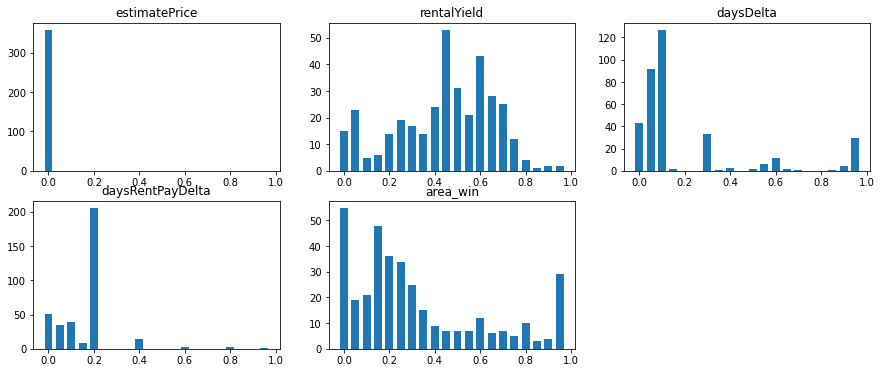

In [76]:
visualize_distributions({
    'estimatePrice': df_num['estimatePrice'],
    'rentalYield': df_num['rentalYield'],
    'daysDelta': df_num['daysDelta'],
    'daysRentPayDelta': df_num['daysRentPayDelta'],
    'area_win': df_num['area_win']        
})

As we can see only **rentalYield** feature has a distribution which is close to normal. All the other features have different distributions, especially strange one is **estimatePrice**. Let's see how their distributions will look like after applying Logarithmization

In [77]:
df_num2 = df_num[['estimatePrice', 'daysDelta', 'daysRentPayDelta', 'area_win']]

In [78]:
# Applying logarithmization to the numerical features, to also avoid errors in case the value is 0
df_num2['estimatePrice'] = df_num2['estimatePrice'].apply(lambda x: x if x == 0 else np.log(x))
df_num2['daysDelta'] = df_num2['daysDelta'].apply(lambda x: x if x == 0 else np.log(x))
df_num2['daysRentPayDelta'] = df_num2['daysRentPayDelta'].apply(lambda x: x if x == 0 else np.log(x))
df_num2['area_win'] = df_num2['area_win'].apply(lambda x: x if x == 0 else np.log(x))

<ipython-input-78-f2878212d206>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num2['estimatePrice'] = df_num2['estimatePrice'].apply(lambda x: x if x == 0 else np.log(x))
<ipython-input-78-f2878212d206>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num2['daysDelta'] = df_num2['daysDelta'].apply(lambda x: x if x == 0 else np.log(x))
<ipython-input-78-f2878212d206>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [79]:
df_num2.head()

,estimatePrice,daysDelta,daysRentPayDelta,area_win
0,-5.403573,0.000000,-1.436545,-1.723639
1,-7.390136,0.000000,-1.436545,-2.359572
2,-3.827617,-2.332327,-1.436545,-0.014975
3,-4.189120,-2.332327,-1.436545,-0.600405
4,-3.914433,-4.051327,-0.848515,-0.378578


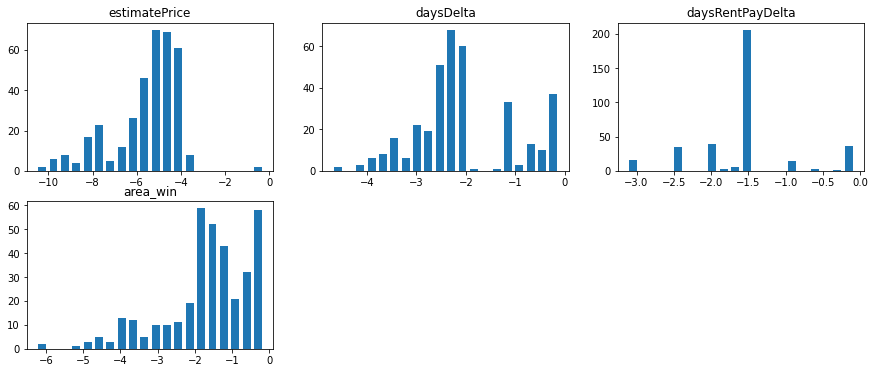

In [80]:
visualize_distributions({
    'estimatePrice': df_num2['estimatePrice'],    
    'daysDelta': df_num2['daysDelta'],
    'daysRentPayDelta': df_num2['daysRentPayDelta'],
    'area_win': df_num2['area_win']        
})

As we can see all the features except **area_win** feature now look more close to a Normal distribution, so probably it makes sense to use logarithmization of these three features, but we will check this hypothesis later when doing experiments. For now we will keep the numerical features as is.

### Let's now take a look at categorical features

Basically, what we need to do alter categorical features either with One hot encoding or with labelling

In [81]:
df_cat = df[cat_col]

In [82]:
# Label Encoding
for column in cat_col:
    df_cat[column] = df_cat[column].astype('category').cat.codes

<ipython-input-82-92abb00026ad>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat[column] = df_cat[column].astype('category').cat.codes


In [83]:
# One-Hot Encoding
df_cat = pd.get_dummies(df_cat, columns=cat_col, dummy_na=False)

In [84]:
df_cat.head()

,status_0,region_id_0,region_id_1,region_id_2,region_id_3,region_id_4,region_id_5,region_id_6,region_id_7,region_id_8,...,estimateDay_26,estimateDay_27,estimateDay_28,estimateDay_29,estimateDay_30,estimateYear_0,estimateYear_1,estimateYear_2,daysRentPayDeltaSign_0,daysRentPayDeltaSign_1
0,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0
1,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [85]:
df_cat.shape

(359, 753)

### Let's now concatenate both categorical and numerical feature after preprocessing into one DataFrame

In [86]:
df_result = pd.concat([df_num, df_cat], axis=1)

In [87]:
df_result.shape

(359, 758)

In [88]:
df_result.head()

,estimatePrice,rentalYield,daysDelta,daysRentPayDelta,area_win,status_0,region_id_0,region_id_1,region_id_2,region_id_3,...,estimateDay_26,estimateDay_27,estimateDay_28,estimateDay_29,estimateDay_30,estimateYear_0,estimateYear_1,estimateYear_2,daysRentPayDeltaSign_0,daysRentPayDeltaSign_1
0,0.004500,0.320000,0.000000,0.237748,0.178416,1,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0
1,0.000617,0.146667,0.000000,0.237748,0.094461,1,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0
2,0.021761,0.306667,0.097070,0.237748,0.985136,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,0.015160,0.613333,0.097070,0.237748,0.548589,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,0.019952,0.573333,0.017399,0.428050,0.684835,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [89]:
#Checking for the NaN values just in case
df_result.isnull().sum().sum()

0

Well, I guess we're ready to experiment with the models

## Models

In [90]:
# Splitting data
X_train, X_valid, y_train, y_valid = train_test_split(df_result, y, test_size=VAL_SIZE, shuffle = True, random_state=RANDOM_SEED)

## Model 1: Simple Linear Regression

In [91]:
linreg_model = LinearRegression().fit(X_train, y_train)

In [92]:
y_pred = linreg_model.predict(X_valid)
print(f"The precision of the Linear Regression model on MAPE metric is: {(mape(y_valid, y_pred))*100:0.2f}%")

The precision of the Linear Regression model on MAPE metric is: 3563597672101.61%


Obviously, the default linear regression model doesn't fir for this dataset. Let's try to build a linear regression model basen only on a numeric features

### Model 1.2: Simple Linear Regression Numeric Features Only

In [93]:
df_res_num = df_result[['estimatePrice', 'daysDelta', 'daysRentPayDelta', 'area_win']]

In [94]:
# Splitting data
X_train_num, X_valid_num, y_train_num, y_valid_num = train_test_split(df_res_num, y, test_size=VAL_SIZE, shuffle = True, random_state=RANDOM_SEED)

In [95]:
linreg_num_model = LinearRegression().fit(X_train_num, y_train_num)

In [96]:
y_pred_num = linreg_num_model.predict(X_valid_num)
print(f"The precision of the Linear Regression model on MAPE metric is: {(mape(y_valid_num, y_pred_num))*100:0.2f}%")

The precision of the Linear Regression model on MAPE metric is: 47.30%


Well, the result which is based only on numeric features is definitely better than the one with all the features, but it is still worse than the results of the default model. It looks like Linear Regression is definitely not the best model to use in this case.

## Model 2: CatboostRegressor

In [97]:
model_catboost = CatBoostRegressor(iterations = 5000,                       
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500                          
                         )
model_catboost.fit(X_train, y_train,
         eval_set=(X_valid, y_valid),
         verbose_eval=100,
         use_best_model=True       
         )

Learning rate set to 0.015833
0:	learn: 0.5163831	test: 0.4887893	best: 0.4887893 (0)	total: 188ms	remaining: 15m 38s
100:	learn: 0.3591576	test: 0.3384567	best: 0.3384567 (100)	total: 413ms	remaining: 20s
200:	learn: 0.2883918	test: 0.2758998	best: 0.2758427 (199)	total: 629ms	remaining: 15s
300:	learn: 0.2484842	test: 0.2443851	best: 0.2443851 (300)	total: 856ms	remaining: 13.4s
400:	learn: 0.2172466	test: 0.2248070	best: 0.2248070 (400)	total: 1.08s	remaining: 12.4s
500:	learn: 0.1949996	test: 0.2159439	best: 0.2159381 (499)	total: 1.31s	remaining: 11.8s
600:	learn: 0.1741024	test: 0.2077667	best: 0.2077656 (599)	total: 1.52s	remaining: 11.1s
700:	learn: 0.1572445	test: 0.2022013	best: 0.2021932 (699)	total: 1.75s	remaining: 10.7s
800:	learn: 0.1477150	test: 0.1991539	best: 0.1989908 (798)	total: 1.96s	remaining: 10.3s
900:	learn: 0.1384819	test: 0.1964452	best: 0.1964401 (899)	total: 2.22s	remaining: 10.1s
1000:	learn: 0.1301963	test: 0.1939316	best: 0.1939281 (999)	total: 2.43s	re

In [98]:
test_predict_catboost = model_catboost.predict(X_valid)
print(f"The precision of the Catboosting Regressor by the MAPE metrics is: {(mape(y_valid, test_predict_catboost))*100:0.2f}%")

The precision of the Catboosting Regressor by the MAPE metrics is: 16.30%


So, with initial CatBoost setup we were able to improve the default model metrics and get pretty good result. Let's think how to improve it

## Model 3: Gradient Boosting

In [99]:
# Default Gradient Bossting Regressor
model_gbr = GradientBoostingRegressor(n_estimators=300, random_state=RANDOM_SEED)
model_gbr.fit(X_train, y_train)
y_pred_gbr = model_gbr.predict(X_valid)
print(f"The precision of the default Gradient Bossting Regressor model on MAPE metric is: {(mape(y_valid, y_pred_gbr))*100:0.2f}%")

The precision of the default Gradient Bossting Regressor model on MAPE metric is: 18.03%


As we can see the result of the default Gradient Boosting Regressor model is much better than default model, however, not as good as CatBoosting. Let's try to fine-tune the Gradient Boosting with hyperparameters

### Model 3.1: Gradient Boosting with Hyperparameters Tuned

In [100]:
gbr = GradientBoostingRegressor()
parameters = {
    "n_estimators":[5,50,250,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]
}

In [101]:
# Using Grid Search to find the best parameters
'''cv_gbr = GridSearchCV(gbr,parameters,cv=5, n_jobs=-1)
cv_gbr.fit(X_train,y_train)'''

'cv_gbr = GridSearchCV(gbr,parameters,cv=5, n_jobs=-1)\ncv_gbr.fit(X_train,y_train)'

In [102]:
#cv_gbr.best_params_

In [103]:
# Gradient Bossting Regressor with hyperparameters tuned
model_gbr_1 = GradientBoostingRegressor(n_estimators=250, learning_rate= 0.1, max_depth=5, random_state=RANDOM_SEED)
model_gbr_1.fit(X_train, y_train)
y_pred_gbr_1 = model_gbr_1.predict(X_valid)
print(f"The precision of the Gradient Bossting Regressor with hyperparameters tuned on MAPE metric is: {(mape(y_valid, y_pred_gbr_1))*100:0.2f}%")

The precision of the Gradient Bossting Regressor with hyperparameters tuned on MAPE metric is: 16.19%


Wow, with the hyperparameters tuned for Gradient Booster Regressor we were able to achieve even better score than CatBoosting Regressor. 

## Model 4:  Default Decision Tree Regressor

In [104]:
# Default Decision Tree Regressor
model_dectree = DecisionTreeRegressor(random_state = RANDOM_SEED)
model_dectree.fit(X_train, y_train)
y_pred_dectree = model_dectree.predict(X_valid)
print(f"The precision of the DecisionTreeRegressor model by the MAPE metrics is: {(mape(y_valid, y_pred_dectree))*100:0.2f}%")

The precision of the DecisionTreeRegressor model by the MAPE metrics is: 18.61%


### Model 4.1 Decision Tree Regressor With Hyperparameters Tuned

Well, the the results of the default Decision Tree Model are not very promising, but anyway let's try to play with the hyperparameters tuning

In [105]:
dtr = DecisionTreeRegressor(random_state = RANDOM_SEED)

parameters_dtr = {"splitter":["best","random"],
            "max_depth" : [7,9,11,12],
           "min_samples_leaf":[1,2,3,6,7,8],
           "min_weight_fraction_leaf":[0.1,0.3, 0.5],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50] }

In [106]:
# Using Grid Search to find the best parameters
#cv_dtr = GridSearchCV(dtr,parameters_dtr, cv=5, n_jobs=-1)
#cv_dtr.fit(X_train,y_train)

In [107]:
# best hyperparameters
#cv_dtr.best_params_

In [108]:
# Decision Tree Regressor with the best hyperparameters
model_dectree_1 = DecisionTreeRegressor(max_depth = 7, max_features = 'auto', min_samples_leaf = 1,
                                      min_weight_fraction_leaf = 0.1, splitter = 'best', random_state = RANDOM_SEED)
model_dectree_1.fit(X_train, y_train)
y_pred_dectree_1 = model_dectree_1.predict(X_valid)
print(f"The precision of the DecisionTreeRegressor model by the MAPE metrics is: {(mape(y_valid, y_pred_dectree_1))*100:0.2f}%")

The precision of the DecisionTreeRegressor model by the MAPE metrics is: 38.77%


The Decision Tree regressor with hyperparameters tuned showed even worse result than without hyperparameters. So, we would probably refuse using this model

## Model 5: Random Forest Regressor

In [109]:
# Default Random Forest Regressor
model_randfor = RandomForestRegressor(n_estimators = 100, random_state = RANDOM_SEED)
model_randfor.fit(X_train, y_train)  
y_pred_randfor = model_randfor.predict(X_valid)
print(f"The precision of the default Random Forest Regressor on the MAPE metrics is: {(mape(y_valid, y_pred_randfor))*100:0.2f}%")

The precision of the default Random Forest Regressor on the MAPE metrics is: 17.88%


As we can see the default Random Forest Regressor showed approximately the same accuracy as the default Gradient Bossting Regressor. So, let's try to play with the hyperparameters to improve the result

### Model 5.1: Random Forest Regressor with the hypermarameters tuned

In [110]:
rf = RandomForestRegressor()

parameters_rf = {
    'bootstrap': [True, False],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3, 5, 10],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

In [111]:
# Using Grid Search to find the best parameters
#cv_randf = GridSearchCV(rf, parameters_rf,cv = 5, n_jobs = -1, verbose = 2)
#cv_randf.fit(X_train, y_train)

In [112]:
# best parameters
#cv_randf.best_params_

In [113]:
# Random Forest Regressor with the best hyperparameters
model_randfor_1 = RandomForestRegressor(bootstrap= 'False', max_depth = 110, max_features = 10, min_samples_leaf = 3, 
                                        min_samples_split = 10, n_estimators = 100, random_state = RANDOM_SEED)
model_randfor_1.fit(X_train, y_train)  
y_pred_randfor_1 = model_randfor_1.predict(X_valid)
print(f"The precision of the Random Forest Regressor with the hyperparameters on the MAPE metrics is: {(mape(y_valid, y_pred_randfor_1))*100:0.2f}%")

The precision of the Random Forest Regressor with the hyperparameters on the MAPE metrics is: 45.84%


As we can see the result of the Random Forest Regressor with the best hyperparameters is worse than the result of the default model. So, we will probably stick to the default model if using this algorithm at all

## Model 6: K-Nearest Neighbors Regressor

In [114]:
# Default K-Nearest Neighbours Regressor
model_knn = KNeighborsRegressor(n_neighbors=2)
model_knn.fit(X_train, y_train)
y_pred_knn = model_knn.predict(X_valid)
print(f"The precision of the default K-Nearest Neighbours Regressor on the MAPE metrics is: {(mape(y_valid, y_pred_knn))*100:0.2f}%")

The precision of the default K-Nearest Neighbours Regressor on the MAPE metrics is: 30.23%


The result of the default K-Nearest Neighbors Regressor doesn't look promising. Probably we even won't play with the hyperparameteres

## Model 7: Support Vector Machine Regressor

In [115]:
# Default Support Vector Machine Regressor
model_svm = SVR(kernel = 'rbf')
model_svm.fit(X_train, y_train)
y_pred_svm = model_svm.predict(X_valid)
print(f"The precision of the default Support Vector Machine Regressor on the MAPE metrics is: {(mape(y_valid, y_pred_svm))*100:0.2f}%")

The precision of the default Support Vector Machine Regressor on the MAPE metrics is: 47.31%


The result of the default Support Vector Machine Regressor doesn't look promising. Probably we even won't play with the hyperparameteres

## Model 8: Ensemble of the Regressors

Let's now try to teach an ensemple of the regression models that prooved themselves the best

In [116]:
# Define basic models
level0 = list()
level0.append(('catb', CatBoostRegressor()))
level0.append(('rand', RandomForestRegressor()))
level0.append(('gradb', GradientBoostingRegressor()))

In [117]:
# Define meta-model
level1 = LinearRegression()

In [118]:
# Ensemble model
model_ens = StackingRegressor(estimators=level0, final_estimator=level1, cv=5, verbose = 100)
model_ens.fit(X_train, y_train)  
y_pred_ens = model_ens.predict(X_valid)
print(f"The precision of the Ensemble Model by the MAPE metrics is: {(mape(y_valid, y_pred_ens))*100:0.2f}%")

Learning rate set to 0.033939
0:	learn: 23992.4215250	total: 2.28ms	remaining: 2.28s
1:	learn: 23747.6507880	total: 4.88ms	remaining: 2.43s
2:	learn: 23496.4424370	total: 7.33ms	remaining: 2.44s
3:	learn: 23279.6107259	total: 9.86ms	remaining: 2.45s
4:	learn: 22994.1623664	total: 12.5ms	remaining: 2.49s
5:	learn: 22836.0826845	total: 15.3ms	remaining: 2.53s
6:	learn: 22682.5470066	total: 17.9ms	remaining: 2.53s
7:	learn: 22469.6949604	total: 20.6ms	remaining: 2.55s
8:	learn: 22261.3390428	total: 23.3ms	remaining: 2.57s
9:	learn: 22080.3089902	total: 26.1ms	remaining: 2.58s
10:	learn: 21868.5621691	total: 28.6ms	remaining: 2.57s
11:	learn: 21708.2066010	total: 31.2ms	remaining: 2.57s
12:	learn: 21503.9089491	total: 34ms	remaining: 2.58s
13:	learn: 21311.9459871	total: 36.6ms	remaining: 2.57s
14:	learn: 21097.0584895	total: 39.3ms	remaining: 2.58s
15:	learn: 20892.5939363	total: 42ms	remaining: 2.58s
16:	learn: 20718.2518612	total: 44.6ms	remaining: 2.58s
17:	learn: 20540.6478050	total: 

159:	learn: 11852.3120199	total: 390ms	remaining: 2.05s
160:	learn: 11834.0901815	total: 393ms	remaining: 2.04s
161:	learn: 11813.0772464	total: 395ms	remaining: 2.04s
162:	learn: 11767.3980746	total: 397ms	remaining: 2.04s
163:	learn: 11754.3251798	total: 399ms	remaining: 2.03s
164:	learn: 11721.8561505	total: 401ms	remaining: 2.03s
165:	learn: 11686.6699424	total: 403ms	remaining: 2.03s
166:	learn: 11673.4013395	total: 405ms	remaining: 2.02s
167:	learn: 11657.4599262	total: 408ms	remaining: 2.02s
168:	learn: 11641.9402681	total: 410ms	remaining: 2.02s
169:	learn: 11608.5940191	total: 412ms	remaining: 2.01s
170:	learn: 11579.7857791	total: 415ms	remaining: 2.01s
171:	learn: 11558.9896684	total: 417ms	remaining: 2s
172:	learn: 11514.1777419	total: 419ms	remaining: 2s
173:	learn: 11479.7867407	total: 421ms	remaining: 2s
174:	learn: 11460.1967854	total: 424ms	remaining: 2s
175:	learn: 11415.7199995	total: 426ms	remaining: 1.99s
176:	learn: 11388.3935341	total: 428ms	remaining: 1.99s
177:

314:	learn: 8551.7221855	total: 743ms	remaining: 1.61s
315:	learn: 8531.6849905	total: 745ms	remaining: 1.61s
316:	learn: 8520.5134044	total: 747ms	remaining: 1.61s
317:	learn: 8502.8062865	total: 749ms	remaining: 1.61s
318:	learn: 8493.7598488	total: 751ms	remaining: 1.6s
319:	learn: 8461.2114220	total: 753ms	remaining: 1.6s
320:	learn: 8452.1287850	total: 755ms	remaining: 1.6s
321:	learn: 8428.3031758	total: 757ms	remaining: 1.59s
322:	learn: 8419.9108909	total: 760ms	remaining: 1.59s
323:	learn: 8394.4775608	total: 762ms	remaining: 1.59s
324:	learn: 8388.3311929	total: 764ms	remaining: 1.59s
325:	learn: 8369.0059070	total: 766ms	remaining: 1.58s
326:	learn: 8362.1929106	total: 768ms	remaining: 1.58s
327:	learn: 8353.6279018	total: 770ms	remaining: 1.58s
328:	learn: 8343.1694556	total: 773ms	remaining: 1.57s
329:	learn: 8319.6601150	total: 775ms	remaining: 1.57s
330:	learn: 8313.4983556	total: 777ms	remaining: 1.57s
331:	learn: 8307.5728394	total: 780ms	remaining: 1.57s
332:	learn: 8

480:	learn: 6657.8641723	total: 1.1s	remaining: 1.18s
481:	learn: 6653.5820045	total: 1.1s	remaining: 1.18s
482:	learn: 6649.3690740	total: 1.1s	remaining: 1.18s
483:	learn: 6638.2938213	total: 1.1s	remaining: 1.18s
484:	learn: 6618.2304967	total: 1.11s	remaining: 1.17s
485:	learn: 6614.3351105	total: 1.11s	remaining: 1.17s
486:	learn: 6610.5080083	total: 1.11s	remaining: 1.17s
487:	learn: 6598.2606937	total: 1.11s	remaining: 1.17s
488:	learn: 6572.7495583	total: 1.11s	remaining: 1.16s
489:	learn: 6568.7883651	total: 1.12s	remaining: 1.16s
490:	learn: 6560.1998526	total: 1.12s	remaining: 1.16s
491:	learn: 6556.2175271	total: 1.12s	remaining: 1.16s
492:	learn: 6550.4580026	total: 1.12s	remaining: 1.16s
493:	learn: 6546.3029257	total: 1.13s	remaining: 1.15s
494:	learn: 6523.0985241	total: 1.13s	remaining: 1.15s
495:	learn: 6519.1581533	total: 1.13s	remaining: 1.15s
496:	learn: 6509.5251533	total: 1.13s	remaining: 1.15s
497:	learn: 6505.4362904	total: 1.13s	remaining: 1.14s
498:	learn: 65

642:	learn: 5453.5084923	total: 1.45s	remaining: 805ms
643:	learn: 5442.9934101	total: 1.45s	remaining: 803ms
644:	learn: 5429.0862064	total: 1.45s	remaining: 800ms
645:	learn: 5426.3123581	total: 1.46s	remaining: 798ms
646:	learn: 5423.7971496	total: 1.46s	remaining: 795ms
647:	learn: 5421.0068901	total: 1.46s	remaining: 793ms
648:	learn: 5416.9186624	total: 1.46s	remaining: 791ms
649:	learn: 5414.0277762	total: 1.46s	remaining: 788ms
650:	learn: 5409.9471128	total: 1.47s	remaining: 786ms
651:	learn: 5405.4421219	total: 1.47s	remaining: 784ms
652:	learn: 5402.7550617	total: 1.47s	remaining: 781ms
653:	learn: 5399.9770916	total: 1.47s	remaining: 779ms
654:	learn: 5397.1180218	total: 1.47s	remaining: 777ms
655:	learn: 5392.5753170	total: 1.48s	remaining: 774ms
656:	learn: 5385.7148272	total: 1.48s	remaining: 772ms
657:	learn: 5373.2113346	total: 1.48s	remaining: 770ms
658:	learn: 5370.5678638	total: 1.48s	remaining: 768ms
659:	learn: 5366.5465502	total: 1.49s	remaining: 765ms
660:	learn

800:	learn: 4532.8031873	total: 1.8s	remaining: 448ms
801:	learn: 4530.6956100	total: 1.81s	remaining: 446ms
802:	learn: 4524.6241615	total: 1.81s	remaining: 444ms
803:	learn: 4522.4040935	total: 1.81s	remaining: 442ms
804:	learn: 4510.1162047	total: 1.81s	remaining: 439ms
805:	learn: 4498.2658948	total: 1.81s	remaining: 437ms
806:	learn: 4496.2309731	total: 1.82s	remaining: 435ms
807:	learn: 4482.0019464	total: 1.82s	remaining: 432ms
808:	learn: 4479.7871128	total: 1.82s	remaining: 430ms
809:	learn: 4474.3464625	total: 1.82s	remaining: 428ms
810:	learn: 4472.0122104	total: 1.82s	remaining: 426ms
811:	learn: 4460.5342720	total: 1.83s	remaining: 423ms
812:	learn: 4456.7157182	total: 1.83s	remaining: 421ms
813:	learn: 4454.7072511	total: 1.83s	remaining: 419ms
814:	learn: 4446.8825642	total: 1.83s	remaining: 416ms
815:	learn: 4441.9164479	total: 1.84s	remaining: 414ms
816:	learn: 4439.7138636	total: 1.84s	remaining: 412ms
817:	learn: 4437.5406209	total: 1.84s	remaining: 410ms
818:	learn:

968:	learn: 3820.2314706	total: 2.16s	remaining: 69.1ms
969:	learn: 3818.5482522	total: 2.16s	remaining: 66.9ms
970:	learn: 3815.8648895	total: 2.16s	remaining: 64.6ms
971:	learn: 3814.1049606	total: 2.17s	remaining: 62.4ms
972:	learn: 3812.3522921	total: 2.17s	remaining: 60.2ms
973:	learn: 3810.7450781	total: 2.17s	remaining: 57.9ms
974:	learn: 3808.1385056	total: 2.17s	remaining: 55.7ms
975:	learn: 3797.2531921	total: 2.17s	remaining: 53.5ms
976:	learn: 3793.0110955	total: 2.18s	remaining: 51.2ms
977:	learn: 3790.6885802	total: 2.18s	remaining: 49ms
978:	learn: 3788.9374676	total: 2.18s	remaining: 46.8ms
979:	learn: 3787.2053771	total: 2.18s	remaining: 44.5ms
980:	learn: 3781.9982359	total: 2.18s	remaining: 42.3ms
981:	learn: 3780.3375173	total: 2.19s	remaining: 40.1ms
982:	learn: 3771.7377966	total: 2.19s	remaining: 37.9ms
983:	learn: 3769.8659160	total: 2.19s	remaining: 35.6ms
984:	learn: 3768.0165554	total: 2.19s	remaining: 33.4ms
985:	learn: 3756.8683692	total: 2.19s	remaining: 3

180:	learn: 11315.7306728	total: 296ms	remaining: 1.34s
181:	learn: 11302.9563469	total: 297ms	remaining: 1.34s
182:	learn: 11273.0619006	total: 299ms	remaining: 1.33s
183:	learn: 11248.6609378	total: 300ms	remaining: 1.33s
184:	learn: 11220.6457042	total: 302ms	remaining: 1.33s
185:	learn: 11200.0865970	total: 304ms	remaining: 1.33s
186:	learn: 11189.7734719	total: 305ms	remaining: 1.33s
187:	learn: 11172.2071576	total: 307ms	remaining: 1.32s
188:	learn: 11153.0232366	total: 308ms	remaining: 1.32s
189:	learn: 11136.0852007	total: 310ms	remaining: 1.32s
190:	learn: 11124.6653921	total: 312ms	remaining: 1.32s
191:	learn: 11107.0493346	total: 313ms	remaining: 1.32s
192:	learn: 11082.6741567	total: 315ms	remaining: 1.32s
193:	learn: 11063.8636061	total: 316ms	remaining: 1.31s
194:	learn: 11045.9192754	total: 318ms	remaining: 1.31s
195:	learn: 11017.6019181	total: 320ms	remaining: 1.31s
196:	learn: 11006.2090281	total: 321ms	remaining: 1.31s
197:	learn: 10982.1264387	total: 323ms	remaining

395:	learn: 7478.4610562	total: 646ms	remaining: 986ms
396:	learn: 7472.8092984	total: 648ms	remaining: 984ms
397:	learn: 7467.2488156	total: 649ms	remaining: 982ms
398:	learn: 7459.6196507	total: 651ms	remaining: 981ms
399:	learn: 7453.8932318	total: 653ms	remaining: 979ms
400:	learn: 7442.5128039	total: 654ms	remaining: 977ms
401:	learn: 7433.4797942	total: 656ms	remaining: 976ms
402:	learn: 7427.7921279	total: 657ms	remaining: 974ms
403:	learn: 7421.8324579	total: 659ms	remaining: 972ms
404:	learn: 7410.5327757	total: 661ms	remaining: 971ms
405:	learn: 7404.7362268	total: 662ms	remaining: 969ms
406:	learn: 7382.4437282	total: 664ms	remaining: 968ms
407:	learn: 7374.2372682	total: 666ms	remaining: 966ms
408:	learn: 7368.8752187	total: 667ms	remaining: 964ms
409:	learn: 7360.0547385	total: 669ms	remaining: 963ms
410:	learn: 7354.3223421	total: 671ms	remaining: 961ms
411:	learn: 7345.9895364	total: 672ms	remaining: 959ms
412:	learn: 7313.1649703	total: 674ms	remaining: 958ms
413:	learn

611:	learn: 5541.8555969	total: 997ms	remaining: 632ms
612:	learn: 5537.3055719	total: 999ms	remaining: 631ms
613:	learn: 5518.7816199	total: 1s	remaining: 629ms
614:	learn: 5505.6541013	total: 1s	remaining: 627ms
615:	learn: 5493.9665416	total: 1s	remaining: 626ms
616:	learn: 5479.4192321	total: 1s	remaining: 624ms
617:	learn: 5476.0434602	total: 1.01s	remaining: 623ms
618:	learn: 5472.8784494	total: 1.01s	remaining: 621ms
619:	learn: 5467.9066735	total: 1.01s	remaining: 619ms
620:	learn: 5451.4770846	total: 1.01s	remaining: 618ms
621:	learn: 5432.3886268	total: 1.01s	remaining: 616ms
622:	learn: 5423.6558387	total: 1.01s	remaining: 615ms
623:	learn: 5418.3278727	total: 1.02s	remaining: 613ms
624:	learn: 5415.0611900	total: 1.02s	remaining: 611ms
625:	learn: 5399.9193185	total: 1.02s	remaining: 610ms
626:	learn: 5396.6784636	total: 1.02s	remaining: 608ms
627:	learn: 5390.6241458	total: 1.02s	remaining: 606ms
628:	learn: 5376.4666579	total: 1.02s	remaining: 605ms
629:	learn: 5362.44085

816:	learn: 4323.2638255	total: 1.35s	remaining: 302ms
817:	learn: 4319.6798904	total: 1.35s	remaining: 300ms
818:	learn: 4317.0288999	total: 1.35s	remaining: 298ms
819:	learn: 4314.7271949	total: 1.35s	remaining: 297ms
820:	learn: 4311.2343990	total: 1.35s	remaining: 295ms
821:	learn: 4308.6671946	total: 1.35s	remaining: 293ms
822:	learn: 4294.0270882	total: 1.36s	remaining: 292ms
823:	learn: 4287.7608886	total: 1.36s	remaining: 290ms
824:	learn: 4283.7116636	total: 1.36s	remaining: 288ms
825:	learn: 4281.3960272	total: 1.36s	remaining: 287ms
826:	learn: 4279.2434490	total: 1.36s	remaining: 285ms
827:	learn: 4275.8721337	total: 1.36s	remaining: 284ms
828:	learn: 4273.6164131	total: 1.37s	remaining: 282ms
829:	learn: 4254.1315030	total: 1.37s	remaining: 280ms
830:	learn: 4251.8354106	total: 1.37s	remaining: 279ms
831:	learn: 4249.5632499	total: 1.37s	remaining: 277ms
832:	learn: 4245.1332476	total: 1.37s	remaining: 275ms
833:	learn: 4238.3442203	total: 1.37s	remaining: 274ms
834:	learn

Learning rate set to 0.032763
0:	learn: 23233.5735256	total: 2.18ms	remaining: 2.18s
1:	learn: 23091.6962315	total: 2.72ms	remaining: 1.36s
2:	learn: 22885.6163897	total: 4.53ms	remaining: 1.51s
3:	learn: 22640.3923373	total: 6.31ms	remaining: 1.57s
4:	learn: 22481.3065100	total: 8.13ms	remaining: 1.62s
5:	learn: 22291.3456033	total: 9.88ms	remaining: 1.64s
6:	learn: 22164.9842175	total: 11.7ms	remaining: 1.66s
7:	learn: 22000.4438978	total: 13.7ms	remaining: 1.7s
8:	learn: 21821.5538380	total: 15.5ms	remaining: 1.71s
9:	learn: 21657.6331292	total: 17.5ms	remaining: 1.74s
10:	learn: 21477.2739964	total: 19.7ms	remaining: 1.77s
11:	learn: 21310.8903705	total: 21.5ms	remaining: 1.77s
12:	learn: 21178.1746288	total: 23.5ms	remaining: 1.78s
13:	learn: 21018.7245430	total: 25.3ms	remaining: 1.78s
14:	learn: 20836.6470344	total: 27.2ms	remaining: 1.78s
15:	learn: 20681.3742931	total: 29.2ms	remaining: 1.79s
16:	learn: 20567.6131350	total: 31ms	remaining: 1.79s
17:	learn: 20410.1392571	total:

199:	learn: 11156.0656207	total: 339ms	remaining: 1.35s
200:	learn: 11130.5470923	total: 340ms	remaining: 1.35s
201:	learn: 11113.8821512	total: 342ms	remaining: 1.35s
202:	learn: 11097.3757931	total: 344ms	remaining: 1.35s
203:	learn: 11077.1407054	total: 345ms	remaining: 1.35s
204:	learn: 11046.2051994	total: 347ms	remaining: 1.34s
205:	learn: 11033.8605964	total: 349ms	remaining: 1.34s
206:	learn: 11020.4090667	total: 351ms	remaining: 1.34s
207:	learn: 11001.0021635	total: 352ms	remaining: 1.34s
208:	learn: 10987.0811985	total: 354ms	remaining: 1.34s
209:	learn: 10922.3553279	total: 355ms	remaining: 1.34s
210:	learn: 10907.4236811	total: 357ms	remaining: 1.33s
211:	learn: 10897.6434590	total: 359ms	remaining: 1.33s
212:	learn: 10848.4060732	total: 361ms	remaining: 1.33s
213:	learn: 10831.1025379	total: 362ms	remaining: 1.33s
214:	learn: 10785.3314055	total: 364ms	remaining: 1.33s
215:	learn: 10764.8898121	total: 366ms	remaining: 1.33s
216:	learn: 10752.5755536	total: 367ms	remaining

402:	learn: 7603.0266042	total: 690ms	remaining: 1.02s
403:	learn: 7594.4591030	total: 692ms	remaining: 1.02s
404:	learn: 7589.0433112	total: 693ms	remaining: 1.02s
405:	learn: 7578.4896763	total: 695ms	remaining: 1.02s
406:	learn: 7573.1384716	total: 697ms	remaining: 1.01s
407:	learn: 7559.1323515	total: 698ms	remaining: 1.01s
408:	learn: 7540.6855879	total: 700ms	remaining: 1.01s
409:	learn: 7512.3255476	total: 702ms	remaining: 1.01s
410:	learn: 7490.8589338	total: 703ms	remaining: 1.01s
411:	learn: 7482.4761472	total: 705ms	remaining: 1s
412:	learn: 7456.1299808	total: 706ms	remaining: 1s
413:	learn: 7450.5425889	total: 708ms	remaining: 1s
414:	learn: 7439.3980123	total: 710ms	remaining: 1s
415:	learn: 7434.1193561	total: 711ms	remaining: 999ms
416:	learn: 7425.8125163	total: 713ms	remaining: 997ms
417:	learn: 7420.5962226	total: 715ms	remaining: 995ms
418:	learn: 7412.4620259	total: 716ms	remaining: 993ms
419:	learn: 7407.2524763	total: 718ms	remaining: 992ms
420:	learn: 7402.02784

610:	learn: 5854.4772852	total: 1.04s	remaining: 662ms
611:	learn: 5851.0029448	total: 1.04s	remaining: 661ms
612:	learn: 5845.5250279	total: 1.04s	remaining: 659ms
613:	learn: 5834.8863499	total: 1.04s	remaining: 657ms
614:	learn: 5810.9686094	total: 1.05s	remaining: 656ms
615:	learn: 5800.9559397	total: 1.05s	remaining: 654ms
616:	learn: 5790.4639120	total: 1.05s	remaining: 652ms
617:	learn: 5777.5621041	total: 1.05s	remaining: 650ms
618:	learn: 5773.8654152	total: 1.05s	remaining: 649ms
619:	learn: 5758.6229214	total: 1.05s	remaining: 647ms
620:	learn: 5753.1791195	total: 1.06s	remaining: 645ms
621:	learn: 5743.8388563	total: 1.06s	remaining: 643ms
622:	learn: 5740.7202725	total: 1.06s	remaining: 642ms
623:	learn: 5735.2421771	total: 1.06s	remaining: 640ms
624:	learn: 5731.8829463	total: 1.06s	remaining: 638ms
625:	learn: 5728.4696929	total: 1.06s	remaining: 637ms
626:	learn: 5724.8722331	total: 1.07s	remaining: 635ms
627:	learn: 5719.5028732	total: 1.07s	remaining: 633ms
628:	learn

820:	learn: 4505.1737787	total: 1.39s	remaining: 303ms
821:	learn: 4502.7602015	total: 1.39s	remaining: 301ms
822:	learn: 4500.6000376	total: 1.39s	remaining: 300ms
823:	learn: 4483.8113709	total: 1.4s	remaining: 298ms
824:	learn: 4480.2907056	total: 1.4s	remaining: 296ms
825:	learn: 4467.9815948	total: 1.4s	remaining: 295ms
826:	learn: 4457.1293641	total: 1.4s	remaining: 293ms
827:	learn: 4454.7171143	total: 1.4s	remaining: 291ms
828:	learn: 4452.7171779	total: 1.4s	remaining: 290ms
829:	learn: 4449.1705441	total: 1.41s	remaining: 288ms
830:	learn: 4443.0429986	total: 1.41s	remaining: 286ms
831:	learn: 4435.1592612	total: 1.41s	remaining: 284ms
832:	learn: 4433.0307856	total: 1.41s	remaining: 283ms
833:	learn: 4430.6915490	total: 1.41s	remaining: 281ms
834:	learn: 4428.5915153	total: 1.41s	remaining: 279ms
835:	learn: 4426.2526815	total: 1.42s	remaining: 278ms
836:	learn: 4411.6322484	total: 1.42s	remaining: 276ms
837:	learn: 4406.8465929	total: 1.42s	remaining: 274ms
838:	learn: 4398

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s
Learning rate set to 0.032763
0:	learn: 24702.7670093	total: 14.2ms	remaining: 14.2s
1:	learn: 24443.1463504	total: 16.1ms	remaining: 8.04s
2:	learn: 24137.6618637	total: 17.8ms	remaining: 5.92s
3:	learn: 23913.0796739	total: 19.5ms	remaining: 4.85s
4:	learn: 23637.6528884	total: 21.2ms	remaining: 4.21s
5:	learn: 23422.2467159	total: 22.8ms	remaining: 3.78s
6:	learn: 23185.2842697	total: 24.6ms	remaining: 3.49s
7:	learn: 22976.0711712	total: 26.4ms	remaining: 3.27s
8:	learn: 22772.3089261	total: 28ms	remaining: 3.09s
9:	learn: 22550.0868920	total: 29.7ms	remaining: 2.94s
10:	learn: 22368.1314832	total: 31.4ms	remaining: 2.83s
11:	learn: 22122.5895350	total: 33.1ms	remaining: 2.73s
12:	learn: 21969.1845915	total: 34.8ms	remaining: 2.64s
13:	learn: 21812.8136828	total: 36.5ms	remaining: 2.57s
14:	learn: 21681.0357654	total: 38.2ms	remaining: 2.5s
15:	learn: 21510.5906125	total: 39.9ms	remaining: 2.45s
16:	lea

174:	learn: 11309.0436196	total: 307ms	remaining: 1.45s
175:	learn: 11285.5160189	total: 309ms	remaining: 1.45s
176:	learn: 11270.4197849	total: 310ms	remaining: 1.44s
177:	learn: 11255.4447561	total: 312ms	remaining: 1.44s
178:	learn: 11225.0892813	total: 314ms	remaining: 1.44s
179:	learn: 11202.8762582	total: 315ms	remaining: 1.44s
180:	learn: 11174.7027235	total: 317ms	remaining: 1.44s
181:	learn: 11140.8805036	total: 319ms	remaining: 1.43s
182:	learn: 11119.0473393	total: 321ms	remaining: 1.43s
183:	learn: 11094.4082112	total: 322ms	remaining: 1.43s
184:	learn: 11057.6749165	total: 324ms	remaining: 1.43s
185:	learn: 11011.3873261	total: 326ms	remaining: 1.43s
186:	learn: 10990.4528623	total: 327ms	remaining: 1.42s
187:	learn: 10971.9078787	total: 329ms	remaining: 1.42s
188:	learn: 10959.4532968	total: 331ms	remaining: 1.42s
189:	learn: 10909.1329168	total: 332ms	remaining: 1.42s
190:	learn: 10869.8193130	total: 334ms	remaining: 1.42s
191:	learn: 10846.1175915	total: 336ms	remaining

382:	learn: 7208.7867149	total: 658ms	remaining: 1.06s
383:	learn: 7203.5968504	total: 660ms	remaining: 1.06s
384:	learn: 7189.4432742	total: 662ms	remaining: 1.06s
385:	learn: 7184.3018534	total: 663ms	remaining: 1.05s
386:	learn: 7175.3288484	total: 665ms	remaining: 1.05s
387:	learn: 7166.8969122	total: 667ms	remaining: 1.05s
388:	learn: 7161.4976736	total: 668ms	remaining: 1.05s
389:	learn: 7131.2658461	total: 670ms	remaining: 1.05s
390:	learn: 7126.2245830	total: 672ms	remaining: 1.05s
391:	learn: 7112.0857016	total: 674ms	remaining: 1.04s
392:	learn: 7107.0868197	total: 675ms	remaining: 1.04s
393:	learn: 7098.2088725	total: 677ms	remaining: 1.04s
394:	learn: 7093.2345740	total: 679ms	remaining: 1.04s
395:	learn: 7068.9383137	total: 680ms	remaining: 1.04s
396:	learn: 7060.1888989	total: 682ms	remaining: 1.03s
397:	learn: 7054.9075712	total: 684ms	remaining: 1.03s
398:	learn: 7047.7491173	total: 685ms	remaining: 1.03s
399:	learn: 7027.6219364	total: 687ms	remaining: 1.03s
400:	learn

587:	learn: 5457.6051275	total: 1.01s	remaining: 708ms
588:	learn: 5454.4591200	total: 1.01s	remaining: 706ms
589:	learn: 5442.2708900	total: 1.01s	remaining: 704ms
590:	learn: 5437.0000266	total: 1.01s	remaining: 702ms
591:	learn: 5414.0561842	total: 1.02s	remaining: 701ms
592:	learn: 5410.8502908	total: 1.02s	remaining: 699ms
593:	learn: 5400.5447995	total: 1.02s	remaining: 697ms
594:	learn: 5376.1351566	total: 1.02s	remaining: 695ms
595:	learn: 5372.7276375	total: 1.02s	remaining: 694ms
596:	learn: 5367.7615977	total: 1.02s	remaining: 692ms
597:	learn: 5364.1422660	total: 1.03s	remaining: 690ms
598:	learn: 5360.8856954	total: 1.03s	remaining: 688ms
599:	learn: 5357.7447515	total: 1.03s	remaining: 687ms
600:	learn: 5354.3880926	total: 1.03s	remaining: 685ms
601:	learn: 5342.9044796	total: 1.03s	remaining: 683ms
602:	learn: 5338.7101117	total: 1.03s	remaining: 681ms
603:	learn: 5319.8017824	total: 1.04s	remaining: 680ms
604:	learn: 5316.7809881	total: 1.04s	remaining: 678ms
605:	learn

791:	learn: 4229.2680097	total: 1.36s	remaining: 357ms
792:	learn: 4226.9211196	total: 1.36s	remaining: 356ms
793:	learn: 4222.3587488	total: 1.36s	remaining: 354ms
794:	learn: 4218.2004059	total: 1.36s	remaining: 352ms
795:	learn: 4211.8632060	total: 1.37s	remaining: 351ms
796:	learn: 4207.4384669	total: 1.37s	remaining: 349ms
797:	learn: 4203.2443590	total: 1.37s	remaining: 347ms
798:	learn: 4195.4921105	total: 1.37s	remaining: 345ms
799:	learn: 4193.1173781	total: 1.37s	remaining: 344ms
800:	learn: 4190.5839410	total: 1.38s	remaining: 342ms
801:	learn: 4188.3030288	total: 1.38s	remaining: 340ms
802:	learn: 4183.5951941	total: 1.38s	remaining: 338ms
803:	learn: 4180.6403026	total: 1.38s	remaining: 337ms
804:	learn: 4166.1280776	total: 1.38s	remaining: 335ms
805:	learn: 4161.4271255	total: 1.38s	remaining: 333ms
806:	learn: 4159.0673489	total: 1.39s	remaining: 331ms
807:	learn: 4157.0517953	total: 1.39s	remaining: 330ms
808:	learn: 4153.7485299	total: 1.39s	remaining: 328ms
809:	learn

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.7s remaining:    0.0s
Learning rate set to 0.032763
0:	learn: 24092.8293796	total: 9.02ms	remaining: 9.01s
1:	learn: 23855.1356566	total: 10.7ms	remaining: 5.34s
2:	learn: 23607.2918388	total: 12.4ms	remaining: 4.12s
3:	learn: 23354.4291293	total: 14.1ms	remaining: 3.52s
4:	learn: 23114.9565140	total: 15.9ms	remaining: 3.16s
5:	learn: 22930.0361980	total: 17.6ms	remaining: 2.92s
6:	learn: 22736.5144497	total: 19.3ms	remaining: 2.74s
7:	learn: 22534.5571288	total: 21ms	remaining: 2.6s
8:	learn: 22334.2512873	total: 22.7ms	remaining: 2.5s
9:	learn: 22184.3162759	total: 24.4ms	remaining: 2.42s
10:	learn: 22030.4733845	total: 26.2ms	remaining: 2.35s
11:	learn: 21828.2508980	total: 27.9ms	remaining: 2.29s
12:	learn: 21674.9443004	total: 29.5ms	remaining: 2.24s
13:	learn: 21556.6925760	total: 31.2ms	remaining: 2.2s
14:	learn: 21398.0930189	total: 32.9ms	remaining: 2.16s
15:	learn: 21223.7499438	total: 34.6ms	remaining: 2.13s
16:	learn

170:	learn: 12232.8578043	total: 297ms	remaining: 1.44s
171:	learn: 12207.4952892	total: 299ms	remaining: 1.44s
172:	learn: 12188.6705623	total: 301ms	remaining: 1.44s
173:	learn: 12129.7380611	total: 303ms	remaining: 1.44s
174:	learn: 12097.5214720	total: 304ms	remaining: 1.43s
175:	learn: 12038.5334948	total: 306ms	remaining: 1.43s
176:	learn: 12019.2293470	total: 308ms	remaining: 1.43s
177:	learn: 11995.8116466	total: 309ms	remaining: 1.43s
178:	learn: 11928.4244184	total: 311ms	remaining: 1.43s
179:	learn: 11871.9592139	total: 313ms	remaining: 1.42s
180:	learn: 11829.8381581	total: 314ms	remaining: 1.42s
181:	learn: 11811.1427593	total: 316ms	remaining: 1.42s
182:	learn: 11789.1455555	total: 318ms	remaining: 1.42s
183:	learn: 11778.6671615	total: 319ms	remaining: 1.42s
184:	learn: 11755.3609654	total: 321ms	remaining: 1.41s
185:	learn: 11727.0780320	total: 323ms	remaining: 1.41s
186:	learn: 11688.5071302	total: 324ms	remaining: 1.41s
187:	learn: 11622.3147867	total: 326ms	remaining

375:	learn: 7495.3899982	total: 649ms	remaining: 1.08s
376:	learn: 7484.2125786	total: 651ms	remaining: 1.07s
377:	learn: 7477.7395882	total: 653ms	remaining: 1.07s
378:	learn: 7471.2200920	total: 654ms	remaining: 1.07s
379:	learn: 7441.7288422	total: 656ms	remaining: 1.07s
380:	learn: 7410.5455630	total: 658ms	remaining: 1.07s
381:	learn: 7393.3786045	total: 659ms	remaining: 1.07s
382:	learn: 7383.4637039	total: 661ms	remaining: 1.06s
383:	learn: 7377.0497872	total: 663ms	remaining: 1.06s
384:	learn: 7365.5954912	total: 664ms	remaining: 1.06s
385:	learn: 7356.1074020	total: 666ms	remaining: 1.06s
386:	learn: 7349.6846145	total: 668ms	remaining: 1.06s
387:	learn: 7320.8356757	total: 669ms	remaining: 1.05s
388:	learn: 7314.6248894	total: 671ms	remaining: 1.05s
389:	learn: 7304.1740258	total: 673ms	remaining: 1.05s
390:	learn: 7297.9191656	total: 674ms	remaining: 1.05s
391:	learn: 7273.7223609	total: 676ms	remaining: 1.05s
392:	learn: 7265.6975283	total: 678ms	remaining: 1.05s
393:	learn

582:	learn: 5594.0640642	total: 1000ms	remaining: 715ms
583:	learn: 5573.5069303	total: 1s	remaining: 713ms
584:	learn: 5569.8528630	total: 1s	remaining: 712ms
585:	learn: 5566.1847406	total: 1s	remaining: 710ms
586:	learn: 5552.8133494	total: 1.01s	remaining: 708ms
587:	learn: 5547.8383077	total: 1.01s	remaining: 707ms
588:	learn: 5528.2026535	total: 1.01s	remaining: 705ms
589:	learn: 5523.2895529	total: 1.01s	remaining: 703ms
590:	learn: 5518.5543060	total: 1.01s	remaining: 701ms
591:	learn: 5513.6597380	total: 1.01s	remaining: 700ms
592:	learn: 5492.8084906	total: 1.02s	remaining: 698ms
593:	learn: 5486.1833086	total: 1.02s	remaining: 696ms
594:	learn: 5482.5171602	total: 1.02s	remaining: 694ms
595:	learn: 5479.1829602	total: 1.02s	remaining: 693ms
596:	learn: 5474.3223152	total: 1.02s	remaining: 691ms
597:	learn: 5471.0552524	total: 1.02s	remaining: 689ms
598:	learn: 5467.8288983	total: 1.03s	remaining: 688ms
599:	learn: 5464.6373126	total: 1.03s	remaining: 686ms
600:	learn: 5461.4

790:	learn: 4300.6985102	total: 1.35s	remaining: 357ms
791:	learn: 4297.3804872	total: 1.35s	remaining: 355ms
792:	learn: 4286.1619926	total: 1.35s	remaining: 354ms
793:	learn: 4282.8920074	total: 1.36s	remaining: 352ms
794:	learn: 4279.6301551	total: 1.36s	remaining: 350ms
795:	learn: 4265.0912166	total: 1.36s	remaining: 349ms
796:	learn: 4259.0632085	total: 1.36s	remaining: 347ms
797:	learn: 4256.3302707	total: 1.36s	remaining: 345ms
798:	learn: 4253.7944303	total: 1.36s	remaining: 343ms
799:	learn: 4251.0409070	total: 1.37s	remaining: 342ms
800:	learn: 4248.6628564	total: 1.37s	remaining: 340ms
801:	learn: 4238.9083034	total: 1.37s	remaining: 338ms
802:	learn: 4236.3293132	total: 1.37s	remaining: 337ms
803:	learn: 4223.1585342	total: 1.37s	remaining: 335ms
804:	learn: 4218.5254888	total: 1.38s	remaining: 333ms
805:	learn: 4216.2106541	total: 1.38s	remaining: 331ms
806:	learn: 4213.0951718	total: 1.38s	remaining: 330ms
807:	learn: 4209.5190027	total: 1.38s	remaining: 328ms
808:	learn

996:	learn: 3474.4798931	total: 1.7s	remaining: 5.13ms
997:	learn: 3472.3451472	total: 1.71s	remaining: 3.42ms
998:	learn: 3463.5279747	total: 1.71s	remaining: 1.71ms
999:	learn: 3461.5923516	total: 1.71s	remaining: 0us
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.6s remaining:    0.0s
Learning rate set to 0.032763
0:	learn: 23982.0343102	total: 2.03ms	remaining: 2.03s
1:	learn: 23854.1896711	total: 3.72ms	remaining: 1.86s
2:	learn: 23662.7536193	total: 5.39ms	remaining: 1.79s
3:	learn: 23421.7850915	total: 7.06ms	remaining: 1.76s
4:	learn: 23207.2735169	total: 8.74ms	remaining: 1.74s
5:	learn: 22984.9381162	total: 10.4ms	remaining: 1.73s
6:	learn: 22800.8659515	total: 12.1ms	remaining: 1.72s
7:	learn: 22594.2904603	total: 13.8ms	remaining: 1.71s
8:	learn: 22416.0630695	total: 15.5ms	remaining: 1.7s
9:	learn: 22265.3162743	total: 17.2ms	remaining: 1.7s
10:	learn: 22145.7405893	total: 18.9ms	remaining: 1.7s
11:	learn: 21969.8713518	total: 20.5ms	remaining: 1.69s
12:	learn: 

149:	learn: 12259.4307012	total: 253ms	remaining: 1.43s
150:	learn: 12227.9858926	total: 255ms	remaining: 1.43s
151:	learn: 12215.1292793	total: 256ms	remaining: 1.43s
152:	learn: 12202.5427634	total: 258ms	remaining: 1.43s
153:	learn: 12157.7824487	total: 260ms	remaining: 1.43s
154:	learn: 12126.5504162	total: 261ms	remaining: 1.42s
155:	learn: 12083.3976982	total: 263ms	remaining: 1.42s
156:	learn: 12073.8838619	total: 265ms	remaining: 1.42s
157:	learn: 12052.7378534	total: 266ms	remaining: 1.42s
158:	learn: 11996.5009985	total: 268ms	remaining: 1.42s
159:	learn: 11972.3608138	total: 270ms	remaining: 1.42s
160:	learn: 11961.2171683	total: 271ms	remaining: 1.41s
161:	learn: 11934.0630656	total: 273ms	remaining: 1.41s
162:	learn: 11904.7339328	total: 275ms	remaining: 1.41s
163:	learn: 11880.6971887	total: 276ms	remaining: 1.41s
164:	learn: 11855.5130896	total: 278ms	remaining: 1.41s
165:	learn: 11815.9228461	total: 280ms	remaining: 1.4s
166:	learn: 11789.4225221	total: 281ms	remaining:

344:	learn: 7906.6009103	total: 604ms	remaining: 1.15s
345:	learn: 7890.1887488	total: 606ms	remaining: 1.15s
346:	learn: 7867.4700636	total: 608ms	remaining: 1.14s
347:	learn: 7861.8117848	total: 609ms	remaining: 1.14s
348:	learn: 7853.9167824	total: 611ms	remaining: 1.14s
349:	learn: 7831.7257929	total: 613ms	remaining: 1.14s
350:	learn: 7792.0045102	total: 614ms	remaining: 1.14s
351:	learn: 7786.0039441	total: 616ms	remaining: 1.13s
352:	learn: 7779.9664785	total: 618ms	remaining: 1.13s
353:	learn: 7768.7413133	total: 619ms	remaining: 1.13s
354:	learn: 7760.1512483	total: 621ms	remaining: 1.13s
355:	learn: 7735.0739529	total: 623ms	remaining: 1.13s
356:	learn: 7729.1545750	total: 624ms	remaining: 1.12s
357:	learn: 7721.0451619	total: 626ms	remaining: 1.12s
358:	learn: 7715.3703934	total: 628ms	remaining: 1.12s
359:	learn: 7709.6283976	total: 629ms	remaining: 1.12s
360:	learn: 7703.9957416	total: 631ms	remaining: 1.12s
361:	learn: 7698.7703103	total: 633ms	remaining: 1.11s
362:	learn

555:	learn: 5747.6907300	total: 956ms	remaining: 763ms
556:	learn: 5744.3311343	total: 958ms	remaining: 762ms
557:	learn: 5728.9587494	total: 959ms	remaining: 760ms
558:	learn: 5725.2559547	total: 961ms	remaining: 758ms
559:	learn: 5713.6489339	total: 963ms	remaining: 756ms
560:	learn: 5709.9791612	total: 964ms	remaining: 755ms
561:	learn: 5704.3788023	total: 966ms	remaining: 753ms
562:	learn: 5700.7230782	total: 968ms	remaining: 751ms
563:	learn: 5690.7676269	total: 969ms	remaining: 749ms
564:	learn: 5687.3638209	total: 971ms	remaining: 748ms
565:	learn: 5670.4071814	total: 973ms	remaining: 746ms
566:	learn: 5666.9846691	total: 974ms	remaining: 744ms
567:	learn: 5663.3660771	total: 976ms	remaining: 742ms
568:	learn: 5649.4585623	total: 978ms	remaining: 741ms
569:	learn: 5645.8570609	total: 979ms	remaining: 739ms
570:	learn: 5640.7865460	total: 981ms	remaining: 737ms
571:	learn: 5637.9032437	total: 983ms	remaining: 735ms
572:	learn: 5633.6545586	total: 984ms	remaining: 733ms
573:	learn

763:	learn: 4331.5389300	total: 1.31s	remaining: 403ms
764:	learn: 4327.2471741	total: 1.31s	remaining: 402ms
765:	learn: 4322.8553128	total: 1.31s	remaining: 400ms
766:	learn: 4308.9214309	total: 1.31s	remaining: 398ms
767:	learn: 4299.8984558	total: 1.31s	remaining: 397ms
768:	learn: 4297.5535360	total: 1.31s	remaining: 395ms
769:	learn: 4280.8614090	total: 1.32s	remaining: 393ms
770:	learn: 4277.4235524	total: 1.32s	remaining: 391ms
771:	learn: 4264.3023720	total: 1.32s	remaining: 390ms
772:	learn: 4261.8447427	total: 1.32s	remaining: 388ms
773:	learn: 4246.2984926	total: 1.32s	remaining: 386ms
774:	learn: 4243.8771654	total: 1.32s	remaining: 385ms
775:	learn: 4231.1617731	total: 1.33s	remaining: 383ms
776:	learn: 4228.7310643	total: 1.33s	remaining: 381ms
777:	learn: 4226.3461008	total: 1.33s	remaining: 379ms
778:	learn: 4223.9753250	total: 1.33s	remaining: 378ms
779:	learn: 4213.2976321	total: 1.33s	remaining: 376ms
780:	learn: 4210.9104679	total: 1.33s	remaining: 374ms
781:	learn

973:	learn: 3285.6058526	total: 1.66s	remaining: 44.2ms
974:	learn: 3283.9438334	total: 1.67s	remaining: 42.9ms
975:	learn: 3274.0702972	total: 1.68s	remaining: 41.2ms
976:	learn: 3267.3089564	total: 1.68s	remaining: 39.5ms
977:	learn: 3265.5212403	total: 1.68s	remaining: 37.8ms
978:	learn: 3263.8899711	total: 1.68s	remaining: 36.1ms
979:	learn: 3259.6117523	total: 1.68s	remaining: 34.4ms
980:	learn: 3249.5428106	total: 1.69s	remaining: 32.6ms
981:	learn: 3247.9177505	total: 1.69s	remaining: 30.9ms
982:	learn: 3246.1876416	total: 1.69s	remaining: 29.2ms
983:	learn: 3244.6093920	total: 1.69s	remaining: 27.5ms
984:	learn: 3242.8843416	total: 1.69s	remaining: 25.8ms
985:	learn: 3241.1629374	total: 1.69s	remaining: 24.1ms
986:	learn: 3239.6426629	total: 1.7s	remaining: 22.3ms
987:	learn: 3237.9377812	total: 1.7s	remaining: 20.6ms
988:	learn: 3233.9893642	total: 1.7s	remaining: 18.9ms
989:	learn: 3232.2161515	total: 1.7s	remaining: 17.2ms
990:	learn: 3230.5771032	total: 1.7s	remaining: 15.5

Unfortunately this particular ensemble of the regressors didn't show the improvement of the score that we saw in CatBooosting and Gradient Bossting Regressors

## Model 9: Simple Dense Neural Network

In [119]:
# Simple Dense Neural Network
model_dnn = Sequential()
model_dnn.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_dnn.add(L.Dropout(0.5))
model_dnn.add(L.Dense(256, activation="relu"))
model_dnn.add(L.Dropout(0.5))
model_dnn.add(L.Dense(1, activation="linear"))

In [120]:
model_dnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               388608    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 520,193
Trainable params: 520,193
Non-trainable params: 0
_________________________________________________________________


In [121]:
optimizer = tf.keras.optimizers.Adam(0.01)
model_dnn.compile(loss='MAPE', optimizer = optimizer, metrics = ['MAPE'])
checkpoint_dnn = ModelCheckpoint('../working/best_model_dnn.hdf5', monitor = ['val_MAPE'], verbose=0, mode='min')
earlystop_dnn = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True)
callbacks_list_dnn = [checkpoint_dnn,earlystop_dnn]

In [122]:
history_dnn = model_dnn.fit(X_train, y_train,
                   batch_size=512,
                   epochs = 500,
                   validation_data = (X_valid, y_valid),
                   callbacks = callbacks_list_dnn,
                   verbose = 0,
                   )

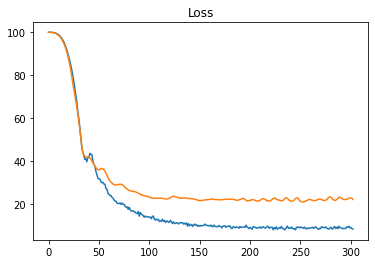

In [123]:
plt.title('Loss')
plt.plot(history_dnn.history['MAPE'], label='train')
plt.plot(history_dnn.history['val_MAPE'], label='test')
plt.show();

In [124]:
model_dnn.load_weights('../working/best_model_dnn.hdf5')
model_dnn.save('../working/nn_1.hdf5')

In [125]:
test_predict_nn1 = model_dnn.predict(X_valid)[:, 0]
print(f"TEST MAPE:{(mape(y_valid, test_predict_nn1))*100:0.2f}%")

TEST MAPE:22.18%


Unfortunately, simple Dense Neural Network with initial parameters wasn't able to produce any better results than regressors did

## Model 10: TabNet 

In [126]:
# Reshaping data to the needed format
'''X = X_train.to_numpy()
y = y_train.to_numpy().reshape(-1, 1)
X_valid = X_valid.to_numpy()'''

'X = X_train.to_numpy()\ny = y_train.to_numpy().reshape(-1, 1)\nX_valid = X_valid.to_numpy()'

In [127]:
# TabNet Neural Network
'''model_tabnet = TabNetRegressor(verbose=0,seed=42)
model_tabnet.fit(X_train=X, y_train=y,
              eval_set=[(X_valid, y_valid)],
              patience=300, max_epochs=2000)'''

'model_tabnet = TabNetRegressor(verbose=0,seed=42)\nmodel_tabnet.fit(X_train=X, y_train=y,\n              eval_set=[(X_valid, y_valid)],\n              patience=300, max_epochs=2000)'

In [128]:
'''test_predict_tabnet = model_tabnet.predict(X_valid)
print(f"The precision of TabNet Neural Network by the MAPE metrics is:{(mape(y_valid, test_predict_tabnet))*100:0.2f}%")'''

'test_predict_tabnet = model_tabnet.predict(X_valid)\nprint(f"The precision of TabNet Neural Network by the MAPE metrics is:{(mape(y_valid, test_predict_tabnet))*100:0.2f}%")'

In [129]:
'''kf = KFold(n_splits=5, random_state=42, shuffle=True)
predictions_array =[]
CV_score_array    =[]
for train_index, test_index in kf.split(X):
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    regressor = TabNetRegressor(verbose=0,seed=42)
    regressor.fit(X_train=X_train, y_train=y_train,
              eval_set=[(X_valid, y_valid)],
              patience=300, max_epochs=2000,
              eval_metric=['rmse'])
    CV_score_array.append(regressor.best_cost)
    predictions_array.append(np.expm1(regressor.predict(X_valid)))

predictions = np.mean(predictions_array,axis=0)'''

"kf = KFold(n_splits=5, random_state=42, shuffle=True)\npredictions_array =[]\nCV_score_array    =[]\nfor train_index, test_index in kf.split(X):\n    X_train, X_valid = X[train_index], X[test_index]\n    y_train, y_valid = y[train_index], y[test_index]\n    regressor = TabNetRegressor(verbose=0,seed=42)\n    regressor.fit(X_train=X_train, y_train=y_train,\n              eval_set=[(X_valid, y_valid)],\n              patience=300, max_epochs=2000,\n              eval_metric=['rmse'])\n    CV_score_array.append(regressor.best_cost)\n    predictions_array.append(np.expm1(regressor.predict(X_valid)))\n\npredictions = np.mean(predictions_array,axis=0)"

In [130]:
'''test_predict_tabnet_1 = regressor.predict(X_valid)
print(f"The precision of TabNet Neural Network by the MAPE metrics is:{(mape(y_valid, test_predict_tabnet_1))*100:0.2f}%")'''

'test_predict_tabnet_1 = regressor.predict(X_valid)\nprint(f"The precision of TabNet Neural Network by the MAPE metrics is:{(mape(y_valid, test_predict_tabnet_1))*100:0.2f}%")'

## Model 11: Blend of the best models

Let's try now to use blend of the best models

In [131]:
# Doing blend prediction of the Catboost algorithm and Gradiend Boosting
blend_predict_1 = (test_predict_catboost + y_pred_gbr_1) / 2
print(f"The precision of the blend of the best models by the MAPE metric is: {(mape(y_valid, blend_predict_1))*100:0.2f}%")

The precision of the blend of the best models by the MAPE metric is: 15.82%


In [132]:
# Doing blend prediction of the Catboost algorithm, Gradient Boosting and Random Forest
blend_predict_2 = (test_predict_catboost + y_pred_gbr_1 + y_pred_randfor) / 3
print(f"The precision of the blend of the best models by the MAPE metric is: {(mape(y_valid, blend_predict_2))*100:0.2f}%")

The precision of the blend of the best models by the MAPE metric is: 16.27%


## Cheking the results

In [133]:
prices_real = y_valid.to_numpy()

In [134]:
prices_pred = y_pred_gbr

In [135]:
d = {'Prices Real': prices_real, 'Prices Predicted': prices_pred}

In [136]:
result = pd.DataFrame(d)

In [137]:
result['Prices Predicted'] = result['Prices Predicted'].apply(lambda x: int(x))

In [138]:
result

,Prices Real,Prices Predicted
0,63489,64207
1,51901,41845
2,66228,76429
3,11023,13367
4,91230,84099
5,38080,47868
6,30365,30975
7,94562,90353
8,53878,62661
9,80477,75337


In [139]:
result.to_excel('prices_comp_v3_available.xlsx', index=False, encoding = 'cp1252')

### Outcomes: 
As we can see when we took only available lots we got much better results then when we were using all the lots from the dataset. And the best score was shown by the blend of CatBoost and Gradient Bosting Algoritms. This is the best result so far

#### To Do: <br>
<li> Experiment with logarithmization </li>
<li> Try different layers for TNN </li>
<li> Try removing those variables were to many options</li>

#### Open questions: <br>
<li> Why linear regression gives such insane values </li>
<li> What metric to choose </li>
<li> Apply linear regression </li>
<li> What to use as a meta algorithm in an ensemable </li>
<li> When exactly to use different regressors </li>